In [1]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time


In [2]:

def evol(output="bank_testdata.csv"):
    iot_data = pd.read_csv('bank_cleaned.csv').iloc[44000:45000]
    y = iot_data['y'].values
    X = iot_data[['age','job','marital','education','default','balance','housing','loan','contact',
                  'day','month','duration','campaign','pdays','previous','poutcome']].values
    start = time.time()
    pop, pareto, logbook = gsvm.gsvm(nqubits=6, depth=3, nparameters=2,
                                     X=X, y=y, weights=[-1.0,1.0],
                                     mu=10,lambda_=5, ngen=5)
    print(f'Simulation finished after {time.time()-start} seconds')
    print(f'\nGenetic-algorithm output ({output})')
    #print('generation, individual, gates/qubit, accuracy')
    print('---------------------------------------------')
    with open(output, "w") as f:
        for ide, ind in enumerate(pareto):
            genes=''.join(str(i) for i in list(ind))
            gates, acc = ind.fitness.values
            line = f'{ide},"{genes}",{gates},{acc}'
            f.write(line)
            f.write('\n')
            print(line)
evol()

multi
String: 101001101100001111010010100001111110111010101010110100000000011111001100011000010000010001
 -> accuracy = 0.56, gates = 14.0,recall = 0.55
String: 110010110011001101001001011010010010010101101111000100011001101011101110010000110011110011
 -> accuracy = 0.54, gates = 11.0,recall = 0.51
String: 011011010110110101101101001101111110011001001111110000110101010011101100001100001010010000
 -> accuracy = 0.545, gates = 10.0,recall = 0.5
String: 010010100001100000110010100000111000100100101010100011100111001111001001011000111000100001
 -> accuracy = 0.555, gates = 18.0,recall = 0.5
String: 000100000000011001111101111110011110110110000010000100110100101110011010100110111110111111
 -> accuracy = 0.525, gates = 13.0,recall = 0.54
String: 100010101000110101100111000111101110110101111011010111011010101011001111110010001001111111
 -> accuracy = 0.57, gates = 14.0,recall = 0.55
String: 111001010110101001101000011010111001100010110110001110001010101001011000001001110110011111
 -> accuracy

In [3]:
import encoding2 as e2
import random

iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,1,1100101100101101011011010011011111100110010011...,2.482379,0.595
1,0,1100101100101001011011011010011111111010010011...,1.348100,0.590


['11001', '01100', '10110', '10110', '11010', '01101', '11111', '00110', '01001', '11111', '01000', '11101', '10101', '11011', '01001', '00011', '00111', '10011']
11.0


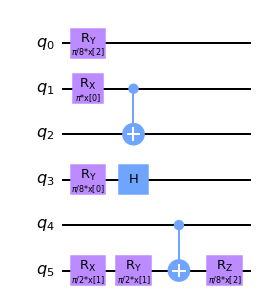

In [4]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
#from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor(nqubits=6, nparameters=3)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [25]:
def featuremap_performance(pop:str,nqubits:int,nparameters:int):
    '''Returns the performance of a feature map on all of the dataset'''

    bank_data = pd.read_csv('bank_cleaned.csv').iloc[41500:45000]

    y = bank_data['y'].values
    X = bank_data[['age','job','marital','education','default','balance',
                'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


    fitness_obj = fitness.Fitness(nqubits,nparameters,X,y,debug=True)

    training_features, training_labels, test_features, test_labels = fitness.Dataset(X,y)

    model = qsvm.QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

    y_pred = model.predict(test_features)

    cm = confusion_matrix(test_labels, y_pred)

    #cm_display = ConfusionMatrixDisplay(cm).plot()
    ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
    plt.show()
    recall = recall_score(test_labels, y_pred)
    acc  = accuracy_score(test_labels, y_pred)

    print(f'String = {pop}, accuracy = {acc}, recall = {recall}')
    return None

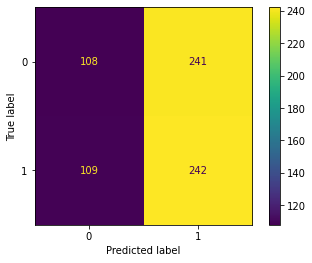

String = 110010110010110101101101001101111110011001001111110100011101101011101101001000110011110011, accuracy = 0.5, recall = 0.6894586894586895


In [26]:
pred = featuremap_performance(iot_salidas.circ[0],6,3)